# Unsupervised Clustering 

In [1]:

import pandas as pd
import numpy as np

# sklearn libraries for clustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
# sklearn libraries for clustering scores when labels are unknown
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.metrics.cluster import davies_bouldin_score
from sklearn.metrics.cluster import silhouette_score
# libraries for viz
import altair as alt
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram, set_link_color_palette

# warning supression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# math items needed for "elbow method"
from math import atan2,degrees

# not needed
# from sklearn.preprocessing import LabelEncoder

## Load Features


In [2]:
csv_data = pd.read_csv('SP500_Index_Normalized_Features.csv')

csv_data['Date'] = pd.to_datetime(csv_data['Date'], format="%Y-%m-%d") #Date column to datetime, just to make sure (this is just a precaution, dataframe should already be in this format)
csv_data = csv_data.sort_values(by='Date', ascending=True).reset_index(drop=True) #dates sorted to better visualize output (this is just a precaution, dataframe should already be in this format)

display(csv_data) # look at the data 

,Date,Ticker,Name,Sector,Price_Returns_12m,Price_Returns_6m,Price_Returns_3m,Price_Returns_1m,Moving_Avg_Returns_12m,Moving_Avg_Returns_6m,...,PB,Trail_EV_EBITDA,Trail_PE,Trail3yrAvg_EPSgro,Trail3yrAvg_DPSgro,Volatility,Debt_to_MktCap,NetDebt_EBITDA,Trail1yr_EPSgro,Trail1yr_DPSgro
0,2001-12-31,DVN,DEVON ENERGY CO,Energy,0.14293,0.36564,0.31219,0.59225,0.41990,0.53320,...,0.01075,0.00267,0.00631,0.41488,0.27215,0.26616,0.08911,0.07375,0.03595,0.25038
1,2001-12-31,HSY,HERSHEY CO/THE,Consumer Staples,0.25097,0.56471,0.28428,0.48704,0.57681,0.66079,...,0.06961,0.00838,0.02737,0.33652,0.31837,0.07804,0.00635,0.07147,0.03728,0.27004
2,2001-12-31,SPGI,S&P GLOBAL INC,Financials,0.24743,0.46879,0.28818,0.53895,0.57295,0.59866,...,0.05470,0.00830,0.02794,0.34179,0.31612,0.15425,0.00590,0.07152,0.04084,0.26100
3,2001-12-31,1255173D,WACHOVIA CORP,Financials,0.27336,0.45867,0.27743,0.46289,0.61219,0.59037,...,0.01080,0.00772,0.01518,0.33330,0.18577,0.17720,0.13291,0.07420,0.04167,0.12517
4,2001-12-31,NEM,NEWMONT CORP,Materials,0.26484,0.52295,0.20880,0.41651,0.60565,0.64239,...,0.02000,0.00697,0.23388,0.49926,0.27215,0.27910,0.02509,0.07331,0.02519,0.25033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113313,2021-06-30,DGX,QUEST DIAGNOSTIC,Health Care,0.11757,0.27166,0.41280,0.34777,0.24272,0.33557,...,0.00654,0.03983,0.00050,0.03751,0.19068,0.16435,0.04361,0.60228,0.25181,0.01069
113314,2021-06-30,ATVI,ACTIVISION BLIZZ,Communication Services,0.13778,0.20577,0.41024,0.30115,0.26987,0.25163,...,0.01378,0.13161,0.00561,0.03104,0.19946,0.24063,0.00912,0.55509,0.21642,0.01146
113315,2021-06-30,ROK,ROCKWELL AUTOMAT,Industrials,0.16258,0.29664,0.47408,0.53138,0.30255,0.35415,...,0.05697,0.16872,0.00639,0.03110,0.19194,0.17081,0.01341,0.60577,0.21064,0.01049
113316,2021-06-30,DXC,DXC TECHNOLOGY C,Information Technology,0.40326,0.57815,0.68071,0.40271,0.59372,0.64506,...,0.00464,0.04439,0.00820,0.02159,0.17359,0.55839,0.13173,0.62643,0.19701,0.00000


In [3]:
### Some items we'll need for each Clustering method
X_features_columns = ['Price_Returns_12m', 'Price_Returns_3m', 'Price_Returns_1m', 'Trail_DivYld', 'PB', 'Trail_EV_EBITDA', 'Trail_PE', 'Trail3yrAvg_EPSgro', 'Trail3yrAvg_DPSgro', 'Volatility', 'Debt_to_MktCap', 'NetDebt_EBITDA', 'Trail1yr_EPSgro', 'Trail1yr_DPSgro']
date_list = list(csv_data.Date.unique())
date_list = date_list[:] #limit dates for testing

print("Number of Features:", len(X_features_columns))
print("Number of Months:", len(date_list))

Number of Features: 14
Number of Months: 235


# Baseline scores
### Create a baseline from the 11 S&P sectors


In [4]:
single_date = '2020-12-31'
X_data = csv_data[csv_data.Date==single_date][X_features_columns]
y_labels = csv_data[csv_data.Date==single_date]['Sector']
print(calinski_harabasz_score(X_data, y_labels))
print(silhouette_score(X_data, y_labels, random_state=0))
print(davies_bouldin_score(X_data, y_labels))

9.171253153760004
-0.13244878496311288
5.057492036667792


In [5]:
df = csv_data.copy()

### lists for the parameter(s) we want to loop through

# None

In [6]:
%%time


def sp500_baseline_scores(df=df, X_features_columns=X_features_columns, date_list=date_list):

    ### modify date list if a smaller set is needed for testing
    date_list = date_list[:]
    #print(date_list)

    ### a blank df with Dates as the index and columns for the data we want to collect 
    optimal_cluster_df = pd.DataFrame(index=date_list, columns=[#'calinski_harabasz_Nclusters', 'silhouette_Nclusters', 'davies_bouldin_Nclusters',
                                                                'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
                                                                'baseline_Nclusters'])
                                                                #'calinski_harabasz_k', 'silhouette_k', 'davies_bouldin_k'])
    #display(optimal_cluster_df)
    
    for date in date_list: 
        print('Now Processing', str(date)[:10] )   
        X_data = df[df.Date==date][X_features_columns]
        #display(X_data)
        y_labels = df[df.Date==date]['Sector']

        #output_list = []


        try:    

            #clustering = KMeans(n_clusters = k, random_state = 0).fit(X_data)
            
            #print(clustering)

            #predicted_labels = clustering.labels_
            num_clusters = len(set(y_labels))
            #print('num_clusters',num_clusters)
            ch = calinski_harabasz_score(X_data, y_labels)
            s = silhouette_score(X_data, y_labels, random_state=0)
            db = davies_bouldin_score(X_data, y_labels)

            #print('num_clusters', num_clusters,'calinski_harabasz (higher better)', ch, 'silhouette (higher better)', s, 'davies_bouldin (lower better)', db, )

            #output_list.append((num_clusters,ch,s,db))
        except:
            continue


        ### update the df with the optimal number of clusters by score
        optimal_cluster_df.loc[date, 'baseline_Nclusters'] = 11
        ### update the df with the score for those optimal clusters
        optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = ch
        optimal_cluster_df.loc[date, 'silhouette_score'] = s
        optimal_cluster_df.loc[date, 'davies_bouldin_score'] = db # Lower is better



    return optimal_cluster_df


baseline_df = sp500_baseline_scores()


Now Processing 2001-12-31
Now Processing 2002-01-31
Now Processing 2002-02-28
Now Processing 2002-03-31
Now Processing 2002-04-30
Now Processing 2002-05-31
Now Processing 2002-06-30
Now Processing 2002-07-31
Now Processing 2002-08-31
Now Processing 2002-09-30
Now Processing 2002-10-31
Now Processing 2002-11-30
Now Processing 2002-12-31
Now Processing 2003-01-31
Now Processing 2003-02-28
Now Processing 2003-03-31
Now Processing 2003-04-30
Now Processing 2003-05-31
Now Processing 2003-06-30
Now Processing 2003-07-31
Now Processing 2003-08-31
Now Processing 2003-09-30
Now Processing 2003-10-31
Now Processing 2003-11-30
Now Processing 2003-12-31
Now Processing 2004-01-31
Now Processing 2004-02-29
Now Processing 2004-03-31
Now Processing 2004-04-30
Now Processing 2004-05-31
Now Processing 2004-06-30
Now Processing 2004-07-31
Now Processing 2004-08-31
Now Processing 2004-09-30
Now Processing 2004-10-31
Now Processing 2004-11-30
Now Processing 2004-12-31
Now Processing 2005-01-31
Now Processi

In [7]:
baseline_df

,calinski_harabasz_score,silhouette_score,davies_bouldin_score,baseline_Nclusters
2001-12-31,14.36,-0.113474,4.19786,11
2002-01-31,13.9454,-0.081999,4.09092,11
2002-02-28,15.0458,-0.0995329,4.88354,11
2002-03-31,12.5373,-0.0768649,4.20345,11
2002-04-30,14.5598,-0.0719668,4.33402,11
...,...,...,...,...
2021-02-28,14.6855,-0.0745819,4.12989,11
2021-03-31,13.0606,-0.0900648,4.16195,11
2021-04-30,12.3059,-0.0852073,4.55115,11
2021-05-31,11.9512,-0.0790654,4.50193,11


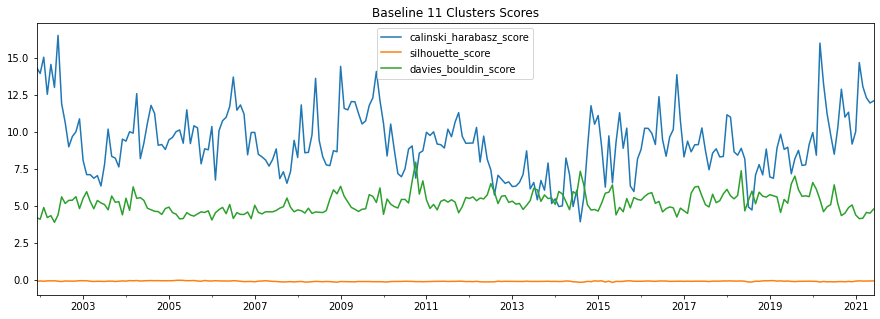

In [8]:
### code to quickly look at our output
baseline_df[[	'calinski_harabasz_score','silhouette_score','davies_bouldin_score']].plot(figsize=(15,5), title='Baseline 11 Clusters Scores');

# Kmeans Clustering
### maximize the cluster quality scores using Kmeans
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html



In [9]:
df = csv_data.copy()

### lists for the parameter(s) we want to loop through

k_params = [k for k in range(2,21)]
print('len(k_params)', len(k_params))
print('k_params',k_params)


len(k_params) 19
k_params [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [10]:
%%time


def sp500_kmeans_cluster(df=df, X_features_columns=X_features_columns, date_list=date_list, k_params=k_params):

    ### modify date list if a smaller set is needed for testing
    date_list = date_list[:]
    #print(date_list)

    ### a blank df with Dates as the index and columns for the data we want to collect 
    optimal_cluster_df = pd.DataFrame(index=date_list, columns=['calinski_harabasz_Nclusters', 'silhouette_Nclusters', 'davies_bouldin_Nclusters',
                                                                'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',])
                                                                #'calinski_harabasz_k', 'silhouette_k', 'davies_bouldin_k'])
    #display(optimal_cluster_df)
    
    for date in date_list: 
        print('Now Processing', str(date)[:10] )   
        X_data = df[df.Date==date][X_features_columns]
        #display(X_data)
        output_list = []

        for k in k_params:
            #print('k: ' + str(k))
            ### we use 'try/except' to allow the code to keep looping if it cannot calculate the information for a certain date & parameter combination, 
            ### for instance if only 1 cluster is returned many calculations cannot proceed
            try:    

                clustering = KMeans(n_clusters = k, random_state = 0).fit(X_data)
                
                #print(clustering)

                predicted_labels = clustering.labels_
                num_clusters = len(set(predicted_labels))
                #print('num_clusters',num_clusters)
                ch = calinski_harabasz_score(X_data, predicted_labels)
                s = silhouette_score(X_data, predicted_labels, random_state=0)
                db = davies_bouldin_score(X_data, predicted_labels)

                #print('k_param',k,'num_clusters', num_clusters,'calinski_harabasz (higher better)', ch, 'silhouette (higher better)', s, 'davies_bouldin (lower better)', db, )

                output_list.append((num_clusters,ch,s,db,k))
            except:
                continue


        ### update the df with the optimal number of clusters by score
        optimal_cluster_df.loc[date, 'calinski_harabasz_Nclusters'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][0]
        optimal_cluster_df.loc[date, 'silhouette_Nclusters'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][0]
        optimal_cluster_df.loc[date, 'davies_bouldin_Nclusters'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][0] # Lower score is Better
        ### update the df with the score for those optimal clusters
        optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][1]
        optimal_cluster_df.loc[date, 'silhouette_score'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][2]
        optimal_cluster_df.loc[date, 'davies_bouldin_score'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][3] # Lower score is Better
        # ### update the df with the parameters for those optimal clusters
        # optimal_cluster_df.loc[date, 'calinski_harabasz_k'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][4]
        # optimal_cluster_df.loc[date, 'silhouette_k'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][4]
        # optimal_cluster_df.loc[date, 'davies_bouldin_k'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][4] # Lower score is Better


    return optimal_cluster_df


km_df = sp500_kmeans_cluster()


Now Processing 2001-12-31
Now Processing 2002-01-31
Now Processing 2002-02-28
Now Processing 2002-03-31
Now Processing 2002-04-30
Now Processing 2002-05-31
Now Processing 2002-06-30
Now Processing 2002-07-31
Now Processing 2002-08-31
Now Processing 2002-09-30
Now Processing 2002-10-31
Now Processing 2002-11-30
Now Processing 2002-12-31
Now Processing 2003-01-31
Now Processing 2003-02-28
Now Processing 2003-03-31
Now Processing 2003-04-30
Now Processing 2003-05-31
Now Processing 2003-06-30
Now Processing 2003-07-31
Now Processing 2003-08-31
Now Processing 2003-09-30
Now Processing 2003-10-31
Now Processing 2003-11-30
Now Processing 2003-12-31
Now Processing 2004-01-31
Now Processing 2004-02-29
Now Processing 2004-03-31
Now Processing 2004-04-30
Now Processing 2004-05-31
Now Processing 2004-06-30
Now Processing 2004-07-31
Now Processing 2004-08-31
Now Processing 2004-09-30
Now Processing 2004-10-31
Now Processing 2004-11-30
Now Processing 2004-12-31
Now Processing 2005-01-31
Now Processi

In [11]:
km_df

,calinski_harabasz_Nclusters,silhouette_Nclusters,davies_bouldin_Nclusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score
2001-12-31,2,2,20,162.789,0.412334,1.03111
2002-01-31,2,2,19,161.052,0.369189,1.14487
2002-02-28,2,2,2,215.814,0.448971,1.0752
2002-03-31,2,2,11,151.346,0.381039,1.17861
2002-04-30,2,2,20,191.026,0.421152,1.11802
...,...,...,...,...,...,...
2021-02-28,2,2,18,155.437,0.309482,1.23197
2021-03-31,3,3,15,134.63,0.244574,1.1811
2021-04-30,3,2,17,109.145,0.26531,1.16166
2021-05-31,2,3,19,114.531,0.222629,1.2188


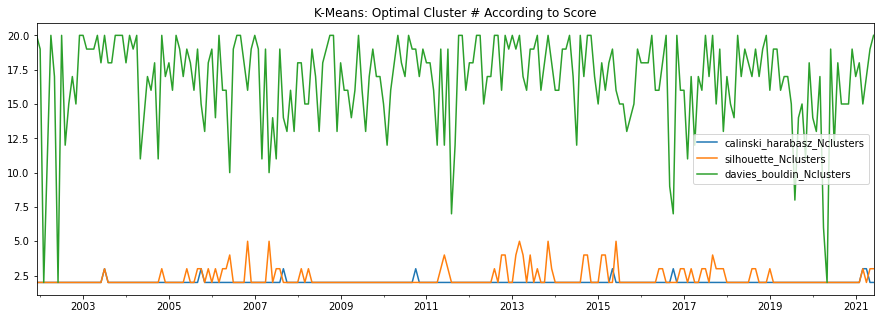

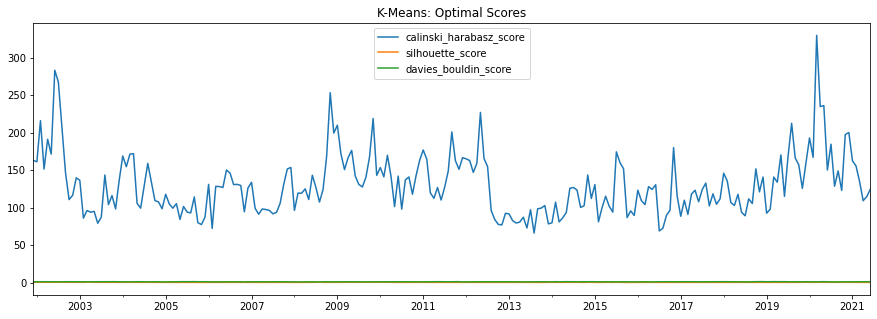

In [12]:
### code to quickly look at our output
km_df[[	'calinski_harabasz_Nclusters','silhouette_Nclusters','davies_bouldin_Nclusters']].plot(figsize=(15,5), title='K-Means: Optimal Cluster # According to Score');
km_df[[	'calinski_harabasz_score','silhouette_score','davies_bouldin_score']].plot(figsize=(15,5), title='K-Means: Optimal Scores');

# Agglomerative Clustering
### "Bottom-up" Clustering
### maximize cluster quality scores
### We use a dendrogram to get a sense of Ward Distance (squared error) to use as our distance threshold parameters

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html




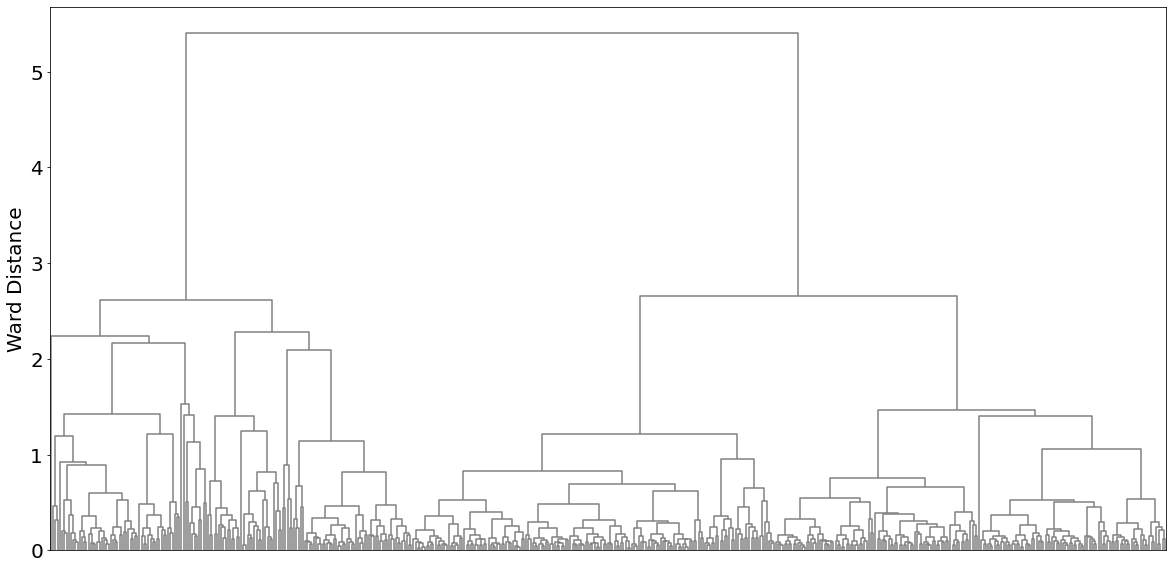

In [13]:
### dendrogram for a single date.  We generated several samples to get a sense for what the range of squared errors (ward distance) was in our normalized data

dendro_date = "2020-12-31"
dendro_data = csv_data.copy()[csv_data.Date == dendro_date][X_features_columns]
plt.figure(figsize=(20, 10), )
set_link_color_palette(['grey', 'blue']) #set a color palette, forcing it all to be grey
dendrogram(ward(dendro_data), color_threshold=10, above_threshold_color=None, no_labels=True)
#plt.title('Dendrogram for {}'.format(dendro_date))
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("Ward Distance", fontsize=20)
plt.show()


In [14]:
df = csv_data.copy()

### lists for the parameter(s) we want to loop through

distance_params = [d for d in np.arange(7, 0.25, -0.25 )]
print('len(distance_params)', len(distance_params))
print('distance_params',distance_params)

len(distance_params) 27
distance_params [7.0, 6.75, 6.5, 6.25, 6.0, 5.75, 5.5, 5.25, 5.0, 4.75, 4.5, 4.25, 4.0, 3.75, 3.5, 3.25, 3.0, 2.75, 2.5, 2.25, 2.0, 1.75, 1.5, 1.25, 1.0, 0.75, 0.5]


In [15]:
%%time



def sp500_agglomerative_cluster(df=df, X_features_columns=X_features_columns, date_list=date_list, distance_params=distance_params):

    ### modify date list if a smaller set is needed for testing
    date_list = date_list[:]
    #print(date_list)

    ### a blank df with Dates as the index and columns for the data we want to collect 
    optimal_cluster_df = pd.DataFrame(index=date_list, columns=['calinski_harabasz_Nclusters', 'silhouette_Nclusters', 'davies_bouldin_Nclusters',
                                                                'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
                                                                'calinski_harabasz_distance', 'silhouette_distance', 'davies_bouldin_distance'])
    #display(optimal_cluster_df)
    
    for date in date_list: 
        print('Now Processing', str(date)[:10] )   
        X_data = df[df.Date==date][X_features_columns]
        #display(X_data)
        output_list = []

        for d in distance_params:
            #print('distance: ' + str(d))
            ### we use 'try/except' to allow the code to keep looping if it cannot calculate the information for a certain date & parameter combination, 
            ### for instance if only 1 cluster is returned many calculations cannot proceed
            try:    

                clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=d).fit(X_data)
                
                #print(clustering)

                predicted_labels = clustering.labels_
                num_clusters = len(set(predicted_labels))
                #print('num_clusters',num_clusters)
                ch = calinski_harabasz_score(X_data, predicted_labels)
                s = silhouette_score(X_data, predicted_labels, random_state=0)
                db = davies_bouldin_score(X_data, predicted_labels)

                #print('distance',d,'num_clusters', num_clusters,'calinski_harabasz (higher better)', ch, 'silhouette (higher better)', s, 'davies_bouldin (lower better)', db, )

                output_list.append((num_clusters,ch,s,db,d))
            except:
                continue


        ### update the df with the optimal number of clusters by score
        optimal_cluster_df.loc[date, 'calinski_harabasz_Nclusters'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][0]
        optimal_cluster_df.loc[date, 'silhouette_Nclusters'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][0]
        optimal_cluster_df.loc[date, 'davies_bouldin_Nclusters'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][0] # Lower score is Better
        ### update the df with the score for those optimal clusters
        optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][1]
        optimal_cluster_df.loc[date, 'silhouette_score'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][2]
        optimal_cluster_df.loc[date, 'davies_bouldin_score'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][3] # Lower score is Better
        # ### update the df with the parameters for those optimal clusters
        optimal_cluster_df.loc[date, 'calinski_harabasz_distance'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][4]
        optimal_cluster_df.loc[date, 'silhouette_distance'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][4]
        optimal_cluster_df.loc[date, 'davies_bouldin_distance'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][4] # Lower score is Better


    return optimal_cluster_df


ag_df = sp500_agglomerative_cluster()


Now Processing 2001-12-31
Now Processing 2002-01-31
Now Processing 2002-02-28
Now Processing 2002-03-31
Now Processing 2002-04-30
Now Processing 2002-05-31
Now Processing 2002-06-30
Now Processing 2002-07-31
Now Processing 2002-08-31
Now Processing 2002-09-30
Now Processing 2002-10-31
Now Processing 2002-11-30
Now Processing 2002-12-31
Now Processing 2003-01-31
Now Processing 2003-02-28
Now Processing 2003-03-31
Now Processing 2003-04-30
Now Processing 2003-05-31
Now Processing 2003-06-30
Now Processing 2003-07-31
Now Processing 2003-08-31
Now Processing 2003-09-30
Now Processing 2003-10-31
Now Processing 2003-11-30
Now Processing 2003-12-31
Now Processing 2004-01-31
Now Processing 2004-02-29
Now Processing 2004-03-31
Now Processing 2004-04-30
Now Processing 2004-05-31
Now Processing 2004-06-30
Now Processing 2004-07-31
Now Processing 2004-08-31
Now Processing 2004-09-30
Now Processing 2004-10-31
Now Processing 2004-11-30
Now Processing 2004-12-31
Now Processing 2005-01-31
Now Processi

In [16]:
ag_df

,calinski_harabasz_Nclusters,silhouette_Nclusters,davies_bouldin_Nclusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,calinski_harabasz_distance,silhouette_distance,davies_bouldin_distance
2001-12-31,2,3,50,133.95,0.384167,1.00194,4.75,2.5,0.5
2002-01-31,2,2,59,133.407,0.377813,1.02778,5,5,0.5
2002-02-28,2,2,61,189.396,0.433926,1.07828,6,6,0.5
2002-03-31,2,2,22,128.426,0.423289,1.13714,4.75,4.75,1
2002-04-30,2,2,61,176.435,0.409857,1.12202,5.75,5.75,0.5
...,...,...,...,...,...,...,...,...,...
2021-02-28,2,2,75,137.912,0.312502,0.994552,6,6,0.5
2021-03-31,3,3,64,117.751,0.245776,1.1144,4.5,4.5,0.5
2021-04-30,2,2,70,90.2222,0.175343,1.01214,4.75,4.75,0.5
2021-05-31,2,3,72,103.777,0.18029,1.07699,5,3.75,0.5


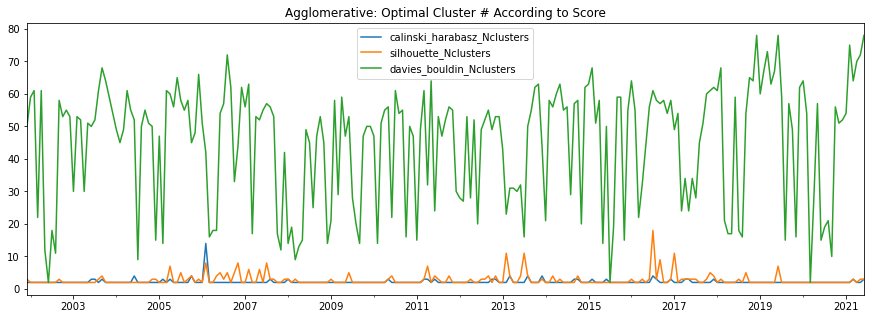

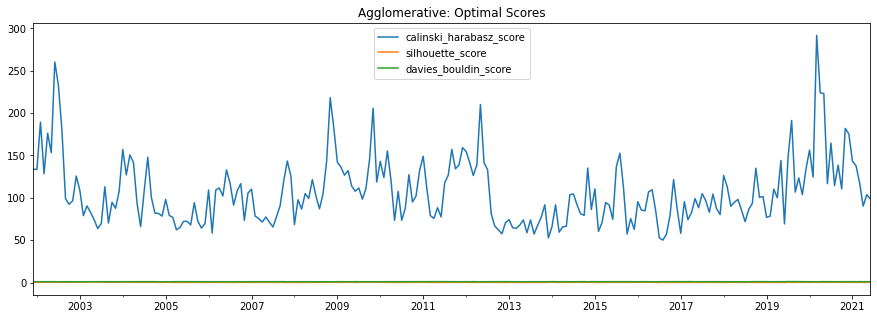

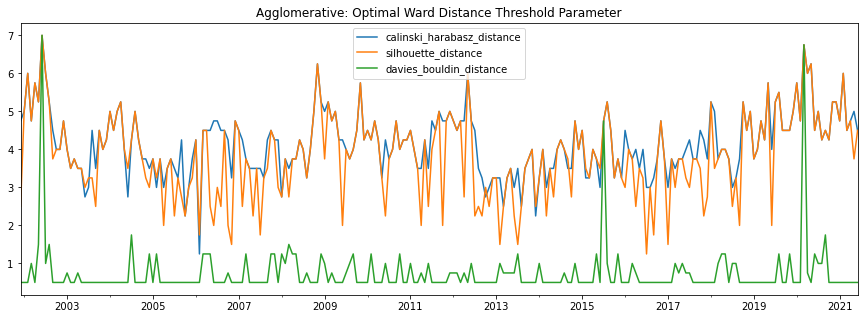

In [17]:
### code to quickly look at our output
ag_df[[	'calinski_harabasz_Nclusters','silhouette_Nclusters','davies_bouldin_Nclusters']].plot(figsize=(15,5), title='Agglomerative: Optimal Cluster # According to Score');
ag_df[[	'calinski_harabasz_score','silhouette_score','davies_bouldin_score']].plot(figsize=(15,5), title='Agglomerative: Optimal Scores');
ag_df[[	'calinski_harabasz_distance','silhouette_distance','davies_bouldin_distance']].plot(figsize=(15,5), title='Agglomerative: Optimal Ward Distance Threshold Parameter');

# Affinity Propogation Clustering
### maximizing cluster quality scores using Affinity Propagation

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html


In [18]:
### dataframe and other objects needed for our clustering
df = csv_data.copy()

### lists for the parameter(s) we want to loop through

damping_params = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
print('len(damping_params)', len(damping_params))
print('damping_params',damping_params)

#preference_params = np.concatenate((np.linspace(-30,0,30,endpoint=False), np.linspace(-1,0,100,endpoint=False)))
preference_params = np.concatenate(( np.linspace(-30,-10,4,endpoint=False), np.linspace(-10,0,10,endpoint=False), np.linspace(-0.8,0,4,endpoint=False), np.linspace(-0.1,0,2,endpoint=False)  ))
print('len(preference_params)', len(preference_params))
print('preference_params',preference_params)

print('Total Parameter Iterations:', len(damping_params)*len(preference_params))

len(damping_params) 6
damping_params [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
len(preference_params) 20
preference_params [-30.   -25.   -20.   -15.   -10.    -9.    -8.    -7.    -6.    -5.
  -4.    -3.    -2.    -1.    -0.8   -0.6   -0.4   -0.2   -0.1   -0.05]
Total Parameter Iterations: 120


In [19]:
%%time




def sp500_affinity_propogation_cluster(df=df, X_features_columns=X_features_columns, date_list=date_list, damping_params=damping_params, preference_params=preference_params):

    ### modify date list if a smaller set is needed for testing
    date_list = date_list[:]
    #print(date_list)

    ### a blank df with Dates as the index and columns for the data we want to collect 
    optimal_cluster_df = pd.DataFrame(index=date_list, columns=['calinski_harabasz_Nclusters', 'silhouette_Nclusters', 'davies_bouldin_Nclusters',
                                                                'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
                                                                'calinski_harabasz_damping', 'silhouette_damping', 'davies_bouldin_damping',
                                                                'calinski_harabasz_preference', 'silhouette_preference', 'davies_bouldin_preference'])
    #display(optimal_cluster_df)

################### COMMENT OUT BELOW UNTIL THE NEXT LINE TO SAVE TIME ON A FULL RUN ###################################    
#     for date in date_list: 
#         print('Now Processing', str(date)[:10] )   
#         X_data = df[df.Date==date][X_features_columns]
#         output_list = []

#         for damping in damping_params:
#             #print('Damping: ' + str(damping))
            
#             for preference in preference_params:
#                 #print('Preference: ' + str(damping))
#                 ### we use 'try/except' to allow the code to keep looping if it cannot calculate the information for a certain date & parameter combination, 
#                 ### for instance if only 1 cluster is returned many calculations cannot proceed
#                 try:    

#                     clustering = AffinityPropagation(damping=damping,
#                                             preference=preference,
#                                             random_state=0).fit(X_data)

#                     #cluster_centers_indices = clustering.cluster_centers_indices_
#                     predicted_labels = clustering.labels_
#                     num_clusters = len(set(predicted_labels))
#                     ch = calinski_harabasz_score(X_data, predicted_labels)
#                     s = silhouette_score(X_data, predicted_labels, random_state=0)
#                     db = davies_bouldin_score(X_data, predicted_labels)

#                     #print('damping',damping,'preference',preference,'num_clusters', num_clusters,'calinski_harabasz (higher better)', ch, 'silhouette (higher better)', s, 'davies_bouldin (lower better)', db, )

#                     output_list.append((num_clusters,ch,s,db,damping,preference))
#                 except:
#                     continue


#         ### update the df with the optimal number of clusters by score
#         optimal_cluster_df.loc[date, 'calinski_harabasz_Nclusters'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][0]
#         optimal_cluster_df.loc[date, 'silhouette_Nclusters'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][0]
#         optimal_cluster_df.loc[date, 'davies_bouldin_Nclusters'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][0] # Lower score is Better
#         ### update the df with the score for those optimal clusters
#         optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][1] 
#         optimal_cluster_df.loc[date, 'silhouette_score'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][2]
#         optimal_cluster_df.loc[date, 'davies_bouldin_score'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][3] # Lower score is Better
#         ### update the df with the parameters for those optimal clusters
#         optimal_cluster_df.loc[date, 'calinski_harabasz_damping'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][4]
#         optimal_cluster_df.loc[date, 'silhouette_damping'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][4]
#         optimal_cluster_df.loc[date, 'davies_bouldin_damping'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][4] # Lower score is Better
#         ### update the df with the parameters for those optimal clusters
#         optimal_cluster_df.loc[date, 'calinski_harabasz_preference'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][5]
#         optimal_cluster_df.loc[date, 'silhouette_preference'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][5]
#         optimal_cluster_df.loc[date, 'davies_bouldin_preference'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][5] # Lower score is Better
########################### COMMENT OUT ABOVE##############################################

    return optimal_cluster_df


af_df = sp500_affinity_propogation_cluster()


CPU times: user 2.36 ms, sys: 95 µs, total: 2.46 ms
Wall time: 2.4 ms


In [46]:
### export Affinity Propogation to drive just in case (take a long time to run)
# af_df.to_csv("af_df_backup.csv", index=True)

### import Affinity Propogation backup csv data if needed
af_df = pd.read_csv('af_df_backup.csv', index_col=0)

In [47]:
af_df

,calinski_harabasz_Nclusters,silhouette_Nclusters,davies_bouldin_Nclusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,calinski_harabasz_damping,silhouette_damping,davies_bouldin_damping,calinski_harabasz_preference,silhouette_preference,davies_bouldin_preference
2001-12-31,2,2,2,160.789927,0.721426,0.196945,0.6,0.99,0.99,-6.0,-0.8,-0.80
2002-01-31,2,2,126,160.055280,0.394525,0.775845,0.5,0.50,0.90,-10.0,-15.0,-0.05
2002-02-28,2,2,135,215.170664,0.463940,0.733902,0.5,0.50,0.90,-25.0,-10.0,-0.05
2002-03-31,2,2,128,150.474582,0.407322,0.753154,0.5,0.60,0.80,-15.0,-7.0,-0.05
2002-04-30,2,2,132,190.783919,0.439781,0.761710,0.6,0.50,0.90,-10.0,-15.0,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,2,2,156,153.298633,0.508065,0.735902,0.5,0.99,0.70,-25.0,-0.6,-0.05
2021-03-31,3,2,128,132.495864,0.325551,0.778438,0.8,0.50,0.90,-7.0,-15.0,-0.05
2021-04-30,3,2,146,106.463071,0.264076,0.762250,0.6,0.90,0.90,-8.0,-15.0,-0.05
2021-05-31,3,3,3,110.186083,0.629043,0.253693,0.5,0.99,0.99,-7.0,-0.4,-0.40


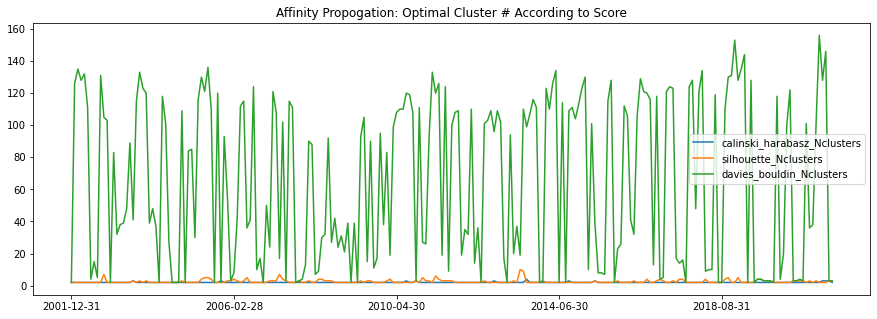

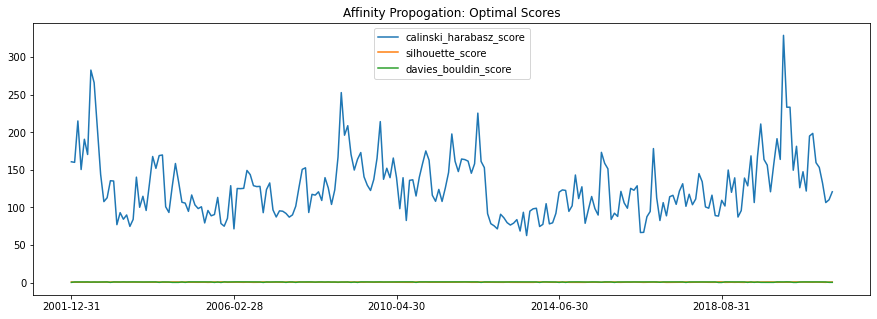

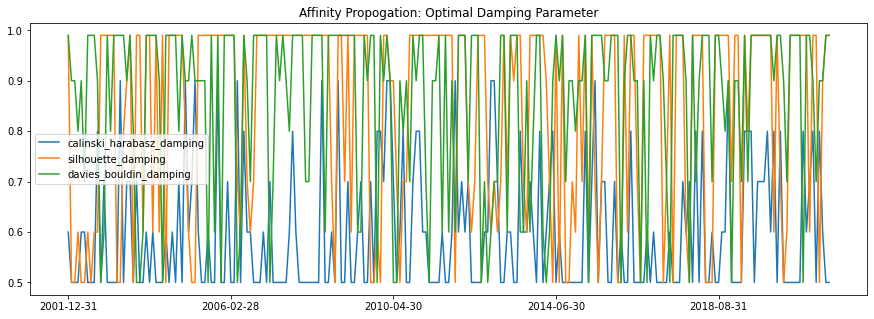

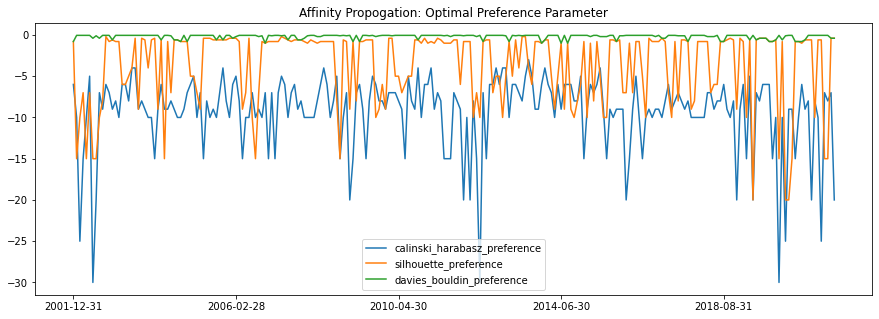

In [48]:
### code to quickly look at our output
af_df[[	'calinski_harabasz_Nclusters','silhouette_Nclusters','davies_bouldin_Nclusters']].plot(figsize=(15,5), title='Affinity Propogation: Optimal Cluster # According to Score');
af_df[[	'calinski_harabasz_score','silhouette_score','davies_bouldin_score']].plot(figsize=(15,5), title='Affinity Propogation: Optimal Scores');
af_df[[	'calinski_harabasz_damping','silhouette_damping','davies_bouldin_damping']].plot(figsize=(15,5), title='Affinity Propogation: Optimal Damping Parameter');
af_df[[	'calinski_harabasz_preference','silhouette_preference','davies_bouldin_preference']].plot(figsize=(15,5), title='Affinity Propogation: Optimal Preference Parameter');

# Viz Comparing 3 Algorithms: Kmeans, Agglomerative, Affinity Propogation
### Looking at ONLY score maximization



In [49]:
### Optimal Cluster by Calinski Harabasz score
optimal_cluster_chart = pd.concat([ baseline_df['baseline_Nclusters'], km_df['calinski_harabasz_Nclusters'], ag_df['calinski_harabasz_Nclusters'], af_df['calinski_harabasz_Nclusters'] ], axis=1)
sort_order_list=['BASELINE S&P','K_Means Max(Calinski Harabasz)','Agglomerative Max(Calinski Harabasz)','Affinity Propogation Max(Calinski Harabasz)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_clusters']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Optimal # of Clusters based on maximizing Calinski Harabasz Score").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_clusters:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'blue', 'purple','orange']),
                    scale = alt.Scale(range = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [50]:
### Optimal SCORE by Calinski Harabasz score
optimal_cluster_chart = pd.concat([ baseline_df['calinski_harabasz_score'], km_df['calinski_harabasz_score'], ag_df['calinski_harabasz_score'], af_df['calinski_harabasz_score']], axis=1)
sort_order_list=['BASELINE S&P','K_Means Max(Calinski Harabasz)','Agglomerative Max(Calinski Harabasz)','Affinity Propogation Max(Calinski Harabasz)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_score']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Calinski Harabasz SCORE of Optimal Clusters (Higher is Better)").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_score:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'blue', 'purple','orange']),
                    scale = alt.Scale(range = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [51]:
### Optimal Cluster by Silhouette score
optimal_cluster_chart = pd.concat([ baseline_df['baseline_Nclusters'] ,km_df['silhouette_Nclusters'], ag_df['silhouette_Nclusters'], af_df['silhouette_Nclusters']], axis=1)
sort_order_list=['BASELINE S&P','K_Means Max(Silhouette score)','Agglomerative Max(Silhouette score)','Affinity Propogation Max(Silhouette score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_clusters']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Optimal # of Clusters based on maximizing Silhouette Score").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_clusters:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'blue', 'purple','orange']),
                    scale = alt.Scale(range = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()



alt.Chart(...)

In [52]:
### Optimal SCORE by Silhouette score
optimal_cluster_chart = pd.concat([ baseline_df['silhouette_score'], km_df['silhouette_score'], ag_df['silhouette_score'], af_df['silhouette_score']], axis=1)
sort_order_list=['BASELINE S&P','K_Means Max(Silhouette score)','Agglomerative Max(Silhouette score)','Affinity Propogation Max(Silhouette score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_score']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Silhouette SCORE of Optimal Clusters (Higher is Better, range of -1 to +1)").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_score:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'blue', 'purple','orange']),
                    scale = alt.Scale(range = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()



alt.Chart(...)

In [53]:
### Optimal Cluster by Davies Bouldin score
optimal_cluster_chart = pd.concat([baseline_df['baseline_Nclusters'], km_df['davies_bouldin_Nclusters'], ag_df['davies_bouldin_Nclusters'], af_df['davies_bouldin_Nclusters']], axis=1)
sort_order_list=['BASELINE S&P','K_Means Max(Davies Bouldin score)','Agglomerative Max(Davies Bouldin score)','Affinity Propogation Max(Davies Bouldin score)']
optimal_cluster_chart.columns=sort_order_list#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_clusters']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Optimal # of Clusters based on maximizing Davies Bouldin Scores").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_clusters:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'blue', 'purple','orange']),
                    scale = alt.Scale(range = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [54]:
### Optimal SCORE by davies_bouldin_ score
optimal_cluster_chart = pd.concat([ baseline_df['davies_bouldin_score'], km_df['davies_bouldin_score'], ag_df['davies_bouldin_score'], af_df['davies_bouldin_score']], axis=1)
sort_order_list=['BASELINE S&P','K_Means Max(Davies Bouldin score)','Agglomerative Max(Davies Bouldin score)','Affinity Propogation Max(Davies Bouldin score)']
optimal_cluster_chart.columns=sort_order_list#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_score']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Davies Bouldin SCORE of Optimal Clusters (Lower is Better, Min score is zero)").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_score:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'blue', 'purple','orange']),
                    scale = alt.Scale(range = ['#d62728', '#1f77b4', '#ff7f0e','#2ca02c']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

# ELBOW METHOD  with Agglomerative
### A different way of "optimizing" the number of clusters based on where the benefit of additional clusters starts to be reduced (based on error).  
### We do this with the "bottom up" agglomerative method, but would like to extend to other methods

In [55]:
### First, test that we have a function that gives us the angle that we want between any two points
### based on help from #https://gist.github.com/darzo27/d25161f13686633bd52162044b30b7db


def GetAngleOfLineBetweenTwoPoints(p1, p2):
    xDiff = p2[0] - p1[0]
    #print(xDiff)
    yDiff = p2[1] - p1[1]
    #print(yDiff)
    return degrees(atan2(yDiff, xDiff))

In [56]:
### test of a 45 degree angle
A = (0, 0)
B = (1, 1)
GetAngleOfLineBetweenTwoPoints(A, B)

45.0

In [57]:
### test of a 135 degree angle (45 degrees + 90 degrees)
A = (0, 0)
B = (-1, 1)
GetAngleOfLineBetweenTwoPoints(A, B)

135.0

In [58]:
### test of any individual point
A = (19, 1)
B = (14, 1.25)
GetAngleOfLineBetweenTwoPoints(A, B)

177.13759477388825

In [59]:
%%time



def sp500_agglomerative_ELBOW_cluster(df=df, X_features_columns=X_features_columns, date_list=date_list, distance_params=distance_params):

    ### modify date list if a smaller set is needed for testing
    date_list = date_list[:]
    #print(date_list)

    ### a blank df with Dates as the index and columns for the data we want to collect 
    # optimal_cluster_df = pd.DataFrame(index=date_list, columns=['calinski_harabasz_Nclusters', 'silhouette_Nclusters', 'davies_bouldin_Nclusters',
    #                                                             'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
    #                                                             'calinski_harabasz_distance', 'silhouette_distance', 'davies_bouldin_distance',
    #                                                             ])
    optimal_cluster_df = pd.DataFrame(index=date_list, columns=['agglo_elbow_distance','agglo_elbow_angle','agglo_elbow_Nclusters' ,
                                                                'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
                                                                ])    
    
    #display(optimal_cluster_df)
    
    for date in date_list: 
        print('Now Processing', str(date)[:10] )   
        X_data = df[df.Date==date][X_features_columns]
        #display(X_data)

        # output_list = []

        prior_d = max(distance_params)
        #print(prior_d)
        prior_num_clusters = np.nan
        target_angle = 135
        target_difference = 100
        optimal_angle = np.nan
        optimal_clusters =np.nan



        for d in distance_params:
            #print('distance: ' + str(d))
            ### we use 'try/except' to allow the code to keep looping if it cannot calculate the information for a certain date & parameter combination, 
            ### for instance if only 1 cluster is returned many calculations cannot proceed
            try:    
                #print('test')
                clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=d).fit(X_data)
                
                #print(clustering)

                predicted_labels = clustering.labels_
                num_clusters = len(set(predicted_labels))
                #print('num_clusters',num_clusters)
                ch = calinski_harabasz_score(X_data, predicted_labels)
                s = silhouette_score(X_data, predicted_labels, random_state=0)
                db = davies_bouldin_score(X_data, predicted_labels)

                point_A = (num_clusters, d)
                point_B = (prior_num_clusters, prior_d)
                #print('point_A',point_A,'point_B',point_B)
                angle = GetAngleOfLineBetweenTwoPoints(point_A, point_B)
                angle_difference = abs(angle - target_angle)
                #print('angle',angle,'angle_difference',angle_difference)

                if angle_difference <= target_difference:
                    optimal_angle = angle
                    optimal_clusters = num_clusters
                    target_difference = angle_difference
                    optimal_cluster_df.loc[date, 'agglo_elbow_distance'] = d
                    optimal_cluster_df.loc[date, 'agglo_elbow_angle'] = optimal_angle
                    optimal_cluster_df.loc[date, 'agglo_elbow_Nclusters'] = num_clusters
                    optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = ch
                    optimal_cluster_df.loc[date, 'silhouette_score'] = s
                    optimal_cluster_df.loc[date, 'davies_bouldin_score'] = db

                #print('angle',angle,'angle_difference',angle_difference,'distance',d,'num_clusters', num_clusters,)#'calinski_harabasz (higher better)', ch, 'silhouette (higher better)', s, 'davies_bouldin (lower better)', db, )

                # output_list.append((num_clusters,ch,s,db,d))

                prior_d = d
                prior_num_clusters = num_clusters
            except:
                continue


        # ### update the df with the optimal number of clusters by score
        # optimal_cluster_df.loc[date, 'calinski_harabasz_Nclusters'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][0]
        # optimal_cluster_df.loc[date, 'silhouette_Nclusters'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][0]
        # optimal_cluster_df.loc[date, 'davies_bouldin_Nclusters'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][0] # Lower score is Better
        # ### update the df with the score for those optimal clusters
        # optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][1]
        # optimal_cluster_df.loc[date, 'silhouette_score'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][2]
        # optimal_cluster_df.loc[date, 'davies_bouldin_score'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][3] # Lower score is Better
        # # ### update the df with the parameters for those optimal clusters
        # optimal_cluster_df.loc[date, 'calinski_harabasz_distance'] = sorted(output_list, key=lambda x: x[1], reverse=True)[0][4]
        # optimal_cluster_df.loc[date, 'silhouette_distance'] = sorted(output_list, key=lambda x: x[2], reverse=True)[0][4]
        # optimal_cluster_df.loc[date, 'davies_bouldin_distance'] = sorted(output_list, key=lambda x: x[3], reverse=False)[0][4] # Lower score is Better


    return optimal_cluster_df


elbow_ag_df = sp500_agglomerative_ELBOW_cluster()


Now Processing 2001-12-31
Now Processing 2002-01-31
Now Processing 2002-02-28
Now Processing 2002-03-31
Now Processing 2002-04-30
Now Processing 2002-05-31
Now Processing 2002-06-30
Now Processing 2002-07-31
Now Processing 2002-08-31
Now Processing 2002-09-30
Now Processing 2002-10-31
Now Processing 2002-11-30
Now Processing 2002-12-31
Now Processing 2003-01-31
Now Processing 2003-02-28
Now Processing 2003-03-31
Now Processing 2003-04-30
Now Processing 2003-05-31
Now Processing 2003-06-30
Now Processing 2003-07-31
Now Processing 2003-08-31
Now Processing 2003-09-30
Now Processing 2003-10-31
Now Processing 2003-11-30
Now Processing 2003-12-31
Now Processing 2004-01-31
Now Processing 2004-02-29
Now Processing 2004-03-31
Now Processing 2004-04-30
Now Processing 2004-05-31
Now Processing 2004-06-30
Now Processing 2004-07-31
Now Processing 2004-08-31
Now Processing 2004-09-30
Now Processing 2004-10-31
Now Processing 2004-11-30
Now Processing 2004-12-31
Now Processing 2005-01-31
Now Processi

In [60]:
elbow_ag_df

,agglo_elbow_distance,agglo_elbow_angle,agglo_elbow_Nclusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score
2001-12-31,2,165.964,6,75.0722,0.168407,1.4251
2002-01-31,1.75,165.964,9,63.1395,0.128436,1.50186
2002-02-28,2.25,165.964,6,89.0599,0.142421,1.56509
2002-03-31,2,165.964,6,64.936,0.156117,1.61156
2002-04-30,2.5,172.875,4,97.8672,0.143295,1.69263
...,...,...,...,...,...,...
2021-02-28,1.75,165.964,13,69.707,0.154739,1.29634
2021-03-31,1.5,165.964,12,69.9698,0.151455,1.35167
2021-04-30,2,165.964,7,64.7116,0.14955,1.76663
2021-05-31,2,165.964,8,67.8085,0.139071,1.5094


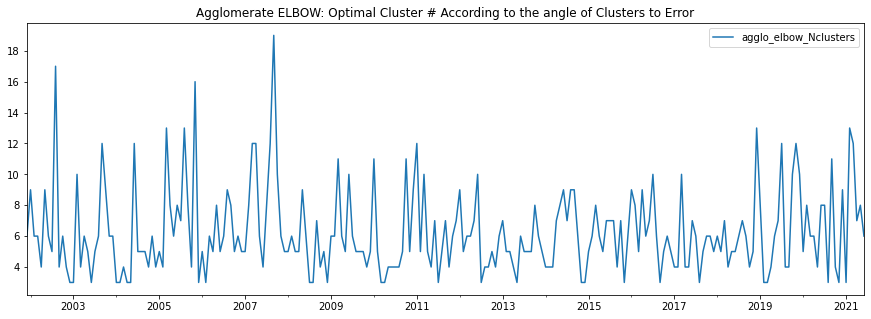

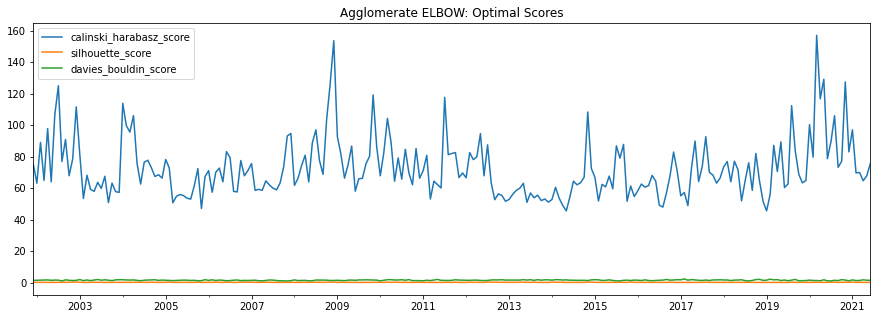

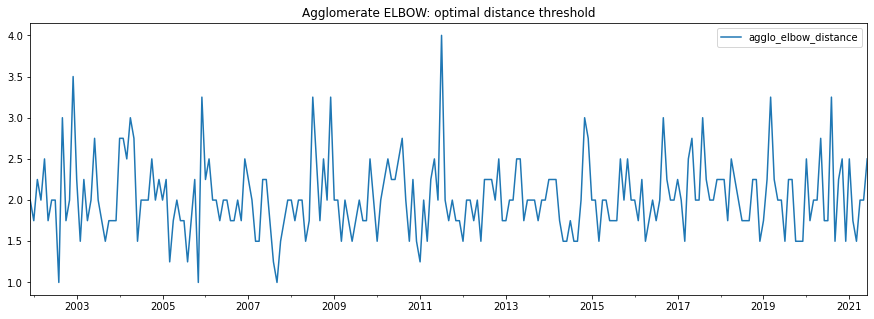

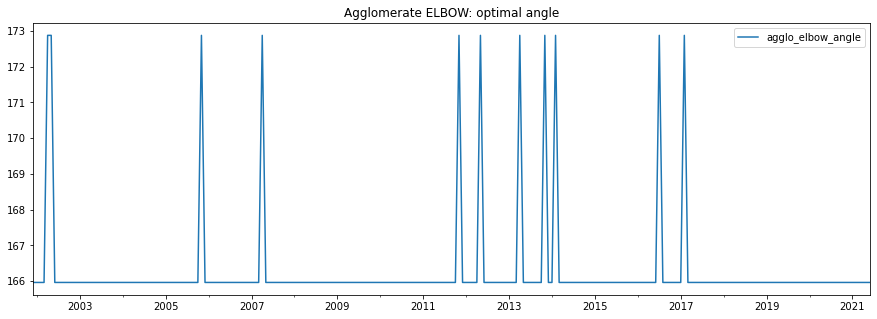

In [61]:
### code to quickly look at our output
elbow_ag_df[[	'agglo_elbow_Nclusters']].plot(figsize=(15,5), title='Agglomerate ELBOW: Optimal Cluster # According to the angle of Clusters to Error');
elbow_ag_df[[	'calinski_harabasz_score','silhouette_score','davies_bouldin_score']].plot(figsize=(15,5), title='Agglomerate ELBOW: Optimal Scores');
elbow_ag_df[[	'agglo_elbow_distance']].plot(figsize=(15,5), title='Agglomerate ELBOW: optimal distance threshold');
elbow_ag_df[[	'agglo_elbow_angle']].plot(figsize=(15,5), title='Agglomerate ELBOW: optimal angle');

# Viz for the "Elbow" method 
### Includes baseline, 3 max-score methods, and the elbow method for Agglomerative

In [62]:
### Optimal Cluster by Calinski Harabasz score
optimal_cluster_chart = pd.concat([baseline_df['baseline_Nclusters'],elbow_ag_df['agglo_elbow_Nclusters'],km_df['calinski_harabasz_Nclusters'], ag_df['calinski_harabasz_Nclusters'], af_df['calinski_harabasz_Nclusters']], axis=1)
sort_order_list=['BASELINE S&P','Agglomerative ELBOW','K_Means Max(Calinski Harabasz score)','Agglomerative Max(Calinski Harabasz score)','Affinity Propogation Max(Calinski Harabasz score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_clusters']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Optimal # of Clusters based on maximizing Calinski Harabasz Score").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_clusters:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'green','light gray', 'light gray','light gray']),
                    scale = alt.Scale(range = ['#d62728', '#9467bd','light gray', 'light gray','light gray']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
                    
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [63]:
### Optimal Cluster by silhouette score
optimal_cluster_chart = pd.concat([baseline_df['baseline_Nclusters'],elbow_ag_df['agglo_elbow_Nclusters'],km_df['silhouette_Nclusters'], ag_df['silhouette_Nclusters'], af_df['silhouette_Nclusters']], axis=1)
sort_order_list=['BASELINE S&P','Agglomerative ELBOW','K_Means Max(Silhouette score)','Agglomerative Max(Silhouette score)','Affinity Propogation Max(Silhouette score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_clusters']
#display(optimal_cluster_chart)

#sort={"encoding": "x", "order": "descending"}

alt.Chart(optimal_cluster_chart, title="Optimal # of Clusters based on maximizing Silhouette Score").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_clusters:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'green','light gray', 'light gray','light gray']),
                    scale = alt.Scale(range = ['#d62728', '#9467bd','light gray', 'light gray','light gray']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
                    
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [64]:
### Optimal Cluster by Davies Bouldin score
optimal_cluster_chart = pd.concat([baseline_df['baseline_Nclusters'],elbow_ag_df['agglo_elbow_Nclusters'],km_df['davies_bouldin_Nclusters'], ag_df['davies_bouldin_Nclusters'], af_df['davies_bouldin_Nclusters']], axis=1)
sort_order_list=['BASELINE S&P','Agglomerative ELBOW','K_Means Min(Davies Bouldin score)','Agglomerative Min(Davies Bouldin score)','Affinity Propogation Min(Davies Bouldin score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_clusters']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Optimal # of Clusters based on minimizing Davies Bouldin Score").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_clusters:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'green','light gray', 'light gray','light gray']),
                    scale = alt.Scale(range = ['#d62728', '#9467bd','light gray', 'light gray','light gray']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
                    
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [65]:
### Optimal SCORE by Calinski Harabasz score
optimal_cluster_chart = pd.concat([baseline_df['calinski_harabasz_score'],elbow_ag_df['calinski_harabasz_score'],km_df['calinski_harabasz_score'], ag_df['calinski_harabasz_score'], af_df['calinski_harabasz_score']], axis=1)
sort_order_list=['BASELINE S&P','Agglomerative ELBOW','K_Means Max(Calinski Harabasz score)','Agglomerative Max(Calinski Harabasz score)','Affinity Propogation Max(Calinski Harabasz score)']
optimal_cluster_chart.columns=sort_order_list#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_score']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Calinski Harabasz SCORE of Optimal Clusters (Higher is Better)").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_score:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'green','light gray', 'light gray','light gray']),
                    scale = alt.Scale(range = ['#d62728', '#9467bd','light gray', 'light gray','light gray']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
                    
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [66]:
### Optimal SCORE by Silhouette score
optimal_cluster_chart = pd.concat([baseline_df['silhouette_score'],elbow_ag_df['silhouette_score'],km_df['silhouette_score'], ag_df['silhouette_score'], af_df['silhouette_score']], axis=1)
sort_order_list=['BASELINE S&P','Agglomerative ELBOW','K_Means Max(Silhouette score)','Agglomerative Max(Silhouette score)','Affinity Propogation Max(Silhouette score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_score']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Silhouette SCORE of Optimal Clusters (Higher is Better, range of -1 to +1)").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_score:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'green','light gray', 'light gray','light gray']),
                    scale = alt.Scale(range = ['#d62728', '#9467bd','light gray', 'light gray','light gray']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

In [67]:
### Optimal SCORE by davies_bouldin_ score
optimal_cluster_chart = pd.concat([baseline_df['davies_bouldin_score'],elbow_ag_df['davies_bouldin_score'],km_df['davies_bouldin_score'], ag_df['davies_bouldin_score'], af_df['davies_bouldin_score']], axis=1)
sort_order_list=['BASELINE S&P','Agglomerative ELBOW','K_Means Max(Davies Bouldin score)','Agglomerative Max(Davies Bouldin score)','Affinity Propogation Max(Davies Bouldin score)']
optimal_cluster_chart.columns=sort_order_list
#display(optimal_cluster_chart)
optimal_cluster_chart = optimal_cluster_chart.stack().reset_index()
optimal_cluster_chart.columns=['Date','Metric','optimal_score']
#display(optimal_cluster_chart)

alt.Chart(optimal_cluster_chart, title="Davies Bouldin SCORE of Optimal Clusters (Lower is Better, Min score is zero)").mark_line().encode(
    x=alt.X('Date:T'),
    y=alt.Y('optimal_score:Q'),
    color=alt.Color('Metric:N', sort=sort_order_list,
                    #scale = alt.Scale(range = ['red', 'green','light gray', 'light gray','light gray']),
                    scale = alt.Scale(range = ['#d62728', '#9467bd','light gray', 'light gray','light gray']),
            legend=alt.Legend(orient="bottom", title=None),
    ),
                    
).properties(
    width=700,
    height=300
)#.interactive()

alt.Chart(...)

## Code needed for a single date's viz of the Agglomerative Elbow Method


In [69]:
################## code to print out a single date of Agglomerative Elbow method for viz #########################

%time



def sp500_agglomerative_ELBOW_single_date_for_viz(df=df, X_features_columns=X_features_columns, date_list=['2020-12-31'], distance_params=distance_params):

    ### modify date list if a smaller set is needed for testing
    date_list = date_list[:]
    #print(date_list)

    ### a blank df with Dates as the index and columns for the data we want to collect 
    # optimal_cluster_df = pd.DataFrame(index=date_list, columns=['calinski_harabasz_Nclusters', 'silhouette_Nclusters', 'davies_bouldin_Nclusters',
    #                                                             'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
    #                                                             'calinski_harabasz_distance', 'silhouette_distance', 'davies_bouldin_distance',
    #                                                             ])
    optimal_cluster_df = pd.DataFrame(index=date_list, columns=['agglo_elbow_distance','agglo_elbow_angle','agglo_elbow_Nclusters' ,
                                                                'calinski_harabasz_score', 'silhouette_score', 'davies_bouldin_score',
                                                                ])    
    
    #display(optimal_cluster_df)
    
    for date in date_list: 
        print('Now Processing', str(date)[:10] )   
        X_data = df[df.Date==date][X_features_columns]
        #display(X_data)

        # output_list = []

        prior_d = max(distance_params)
        #print(prior_d)
        prior_num_clusters = np.nan
        target_angle = 135
        target_difference = 100
        optimal_angle = np.nan
        optimal_clusters =np.nan



        for d in distance_params:
            #print('distance: ' + str(d))
            ### we use 'try/except' to allow the code to keep looping if it cannot calculate the information for a certain date & parameter combination, 
            ### for instance if only 1 cluster is returned many calculations cannot proceed
            try:    
                #print('test')
                clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=d).fit(X_data)
                
                #print(clustering)

                predicted_labels = clustering.labels_
                num_clusters = len(set(predicted_labels))
                #print('num_clusters',num_clusters)
                ch = calinski_harabasz_score(X_data, predicted_labels)
                s = silhouette_score(X_data, predicted_labels, random_state=0)
                db = davies_bouldin_score(X_data, predicted_labels)

                point_A = (num_clusters, d)
                point_B = (prior_num_clusters, prior_d)
                #print('point_A',point_A,'point_B',point_B)
                angle = GetAngleOfLineBetweenTwoPoints(point_A, point_B)
                angle_difference = abs(angle - target_angle)
                #print('angle',angle,'angle_difference',angle_difference)

                if angle_difference <= target_difference:
                    optimal_angle = angle
                    optimal_clusters = num_clusters
                    target_difference = angle_difference
                    optimal_cluster_df.loc[date, 'agglo_elbow_distance'] = d
                    optimal_cluster_df.loc[date, 'agglo_elbow_angle'] = optimal_angle
                    optimal_cluster_df.loc[date, 'agglo_elbow_Nclusters'] = num_clusters
                    optimal_cluster_df.loc[date, 'calinski_harabasz_score'] = ch
                    optimal_cluster_df.loc[date, 'silhouette_score'] = s
                    optimal_cluster_df.loc[date, 'davies_bouldin_score'] = db

                #print('angle',angle,'angle_difference',angle_difference,'distance',d,'num_clusters', num_clusters,)#'calinski_harabasz (higher better)', ch, 'silhouette (higher better)', s, 'davies_bouldin (lower better)', db, )
                print('angle',angle,'distance',d,'num_clusters', num_clusters,)
                # output_list.append((num_clusters,ch,s,db,d))

                prior_d = d
                prior_num_clusters = num_clusters
            except:
                continue


        print('optimal_angle', optimal_angle, 'optimal_clusters', optimal_clusters)
    return optimal_cluster_df


sp500_agglomerative_ELBOW_single_date_for_viz()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs
Now Processing 2020-12-31
angle nan distance 5.25 num_clusters 2
angle 90.0 distance 5.0 num_clusters 2
angle 90.0 distance 4.75 num_clusters 2
angle 90.0 distance 4.5 num_clusters 2
angle 90.0 distance 4.25 num_clusters 2
angle 90.0 distance 4.0 num_clusters 2
angle 90.0 distance 3.75 num_clusters 2
angle 90.0 distance 3.5 num_clusters 2
angle 90.0 distance 3.25 num_clusters 2
angle 90.0 distance 3.0 num_clusters 2
angle 90.0 distance 2.75 num_clusters 2
angle 172.8749836510982 distance 2.5 num_clusters 4
angle 165.96375653207352 distance 2.25 num_clusters 5
angle 175.2363583092738 distance 2.0 num_clusters 8
angle 90.0 distance 1.75 num_clusters 8
angle 165.96375653207352 distance 1.5 num_clusters 9
angle 177.13759477388825 distance 1.25 num_clusters 14
angle 177.9545915111128 distance 1.0 num_clusters 21
angle 178.40885972880542 distance 0.75 num_clusters 30
angle 179.3489396197705 distance 0.5 num_clusters 52
optima

,agglo_elbow_distance,agglo_elbow_angle,agglo_elbow_Nclusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score
2020-12-31,1.5,165.964,9,83.0727,0.181631,1.15178


In [70]:
### END